# 0.0 Imports


In [1]:
import numpy   as np
import pandas  as pd
import seaborn as sns

import umap.umap_ as umap

from IPython.display import HTML
from matplotlib import pyplot as plt


from sklearn import cluster       as c
from sklearn import metrics       as m
from sklearn import preprocessing as pp

from plotly import express as px

from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer ## pip install yellowbrick

## 0.1. Helper Functions


In [2]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'ggplot')
    plt.rcParams['figure.figsize'] = [24, 9]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
    
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## 0.2 Load dataset


In [3]:
# load

df_raw = pd.read_csv('../data/raw/Ecommerce.csv', encoding='unicode_escape', low_memory= False)

df_raw = df_raw.drop( columns= ['Unnamed: 8'], axis = 1)
df_raw.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.0,United Kingdom


# <font color='red'> 1.0. Descrição dos dados </font>


In [4]:
df1 = df_raw.copy()

## 1.1. Rename columns


In [5]:
df1.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

In [6]:
cols_new = ['invoice_no', 'stock_code', 'description','quantity', 'invoice_date', 'unit_price', 'customer_id', 'country']
df1.columns = cols_new

## 1.2. Data dimensions


In [7]:
print( 'Number of rows: {}'.format (df1.shape[0]))
print( 'Number of columns: {}'.format (df1.shape[1]))

Number of rows: 541909
Number of columns: 8


## 1.3. Data types


In [8]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

## 1.4. Check NA


In [9]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

## 1.5. Replace NA


In [10]:
# Remova na
df1 = df1.dropna (subset=['description', 'customer_id'])



print('Removed data: {:.2f}%'.format(1-(df1.shape[0] / df_raw.shape[0])))

Removed data: 0.25%


## 1.6. Change dtypes


In [11]:
df1.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.0,United Kingdom


In [12]:
# invoice date
df1['invoice_date'] = pd.to_datetime( df1['invoice_date'], format='%d-%b-%y' )

# customer id
df1['customer_id'] = df1['customer_id'].astype( int64 )
df1.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2016-11-29,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2016-11-29,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2016-11-29,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2016-11-29,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2016-11-29,3.39,17850,United Kingdom


## 1.7 Descriptive Statistics


In [13]:
num_attributes = df1.select_dtypes ( include=['int64','float64'])
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )

### 1.7.1 Numerical Attributs


In [14]:
# central tendency - mean, median
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T
             
# dispersion - desvio padrão, minimo, maximo, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( np.min ) ).T
d3 = pd.DataFrame( num_attributes.apply( np.max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

# concatenate
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'mediana', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,mediana,std,skew,kurtosis
0,quantity,-80995.0,80995.0,161990.0,12.061303,5.00,248.693064,0.182663,94317.563673
1,unit_price,0.0,38970.0,38970.0,3.460471,1.95,69.315077,452.219019,246924.542988
2,customer_id,12346.0,18287.0,5941.0,15287.690570,15152.00,1713.598197,0.029835,-1.179982


### 1.7.1.1. Numerical Attributs - Investigating


Quantity negativa ( pode ser devolução )

Preço unitário igual a zero ( pode ser promoção? )


### 1.7.2. Categorical Attributs


In [15]:
cat_attributes.head()

,invoice_no,stock_code,description,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,United Kingdom
1,536365,71053,WHITE METAL LANTERN,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,United Kingdom


#### Invoice No


In [16]:
# problema: Temos invoice com letras e numeros
#df1['invoice_no'].astype( int )

# identficacao: 
df_letter_invoices = df1.loc[df1['invoice_no'].apply( lambda x: bool( re.search( '[^0-9]+', x ) ) ), :]
#df_letter_invoices.head()

print( 'Total number of invoices: {}'.format( len( df_letter_invoices ) ) )
# todos os invoice_no que estão com sujeira com letra o quantity é menor que 0 ou seja valores em negativo s
print( 'Total number of negative quantity: {}'.format( len( df_letter_invoices[ df_letter_invoices['quantity'] < 0 ] ) ) )

Total number of invoices: 8905
Total number of negative quantity: 8905


#### Stock Code


In [17]:
# check stock codes only characters
df1.loc[df1['stock_code'].apply( lambda x: bool( re.search( '^[a-zA-Z]+$', x ) ) ), 'stock_code'].unique()

# Acão:
## 1. Remove stock_code in ['POST', 'D', 'M', 'PADS', 'DOT', 'CRUK']

array(['POST', 'D', 'M', 'PADS', 'DOT', 'CRUK'], dtype=object)

# <font color='red'> 2.0. Filtragem de Variaveis </font>


In [19]:
df2 = df1.copy()

In [20]:
df2.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
customer_id              int64
country                 object
dtype: object

In [21]:
# === Numerical attributes ====
df2 = df2.loc[df2['unit_price'] >= 0.04, :]

# === Categorical attributes ====
df2 = df2[~df2['stock_code'].isin( ['POST', 'D', 'M', 'PADS', 'DOT', 'CRUK'] )]  # todos os valores diferentes do in 

# description
df2 = df2.drop( columns='description', axis=1 )

# map 
df2 = df2[~df2['country'].isin( ['European Community', 'Unspecified' ] ) ]

# quantity
df2_returns = df2.loc[df1['quantity'] < 0, :]
df2_purchases = df2.loc[df1['quantity'] >= 0, :]

In [22]:
df2.dtypes

invoice_no              object
stock_code              object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
customer_id              int64
country                 object
dtype: object

# <font color='red'> 3.0. Feature Engineering </font>


In [23]:
df3= df2.copy()

## 3.1. Feature Creation


In [24]:
df3.head()

,invoice_no,stock_code,quantity,invoice_date,unit_price,customer_id,country
0,536365,85123A,6,2016-11-29,2.55,17850,United Kingdom
1,536365,71053,6,2016-11-29,3.39,17850,United Kingdom
2,536365,84406B,8,2016-11-29,2.75,17850,United Kingdom
3,536365,84029G,6,2016-11-29,3.39,17850,United Kingdom
4,536365,84029E,6,2016-11-29,3.39,17850,United Kingdom


In [25]:
# data reference
df_ref = df3.drop( ['invoice_no', 'stock_code', 'quantity', 'invoice_date', 'unit_price', 'country'], axis=1 ).drop_duplicates( ignore_index=True )

In [26]:
# Gross Revenue ( Faturamento ) quantity * price
df2_purchases.loc[:, 'gross_revenue'] = df2_purchases.loc[:, 'quantity'] * df2_purchases.loc[:, 'unit_price']

# Monetary
df_monetary = df2_purchases.loc[:, ['customer_id', 'gross_revenue']].groupby( 'customer_id' ).sum().reset_index()
df_ref = pd.merge( df_ref, df_monetary, on='customer_id', how='left' )
df_ref.isna().sum()

C:\Users\Yves Moura\.conda\envs\DataScienceEmProducao\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


customer_id       0
gross_revenue    27
dtype: int64

In [27]:
# Recency - Last day purchase
df_recency = df2_purchases.loc[:, ['customer_id', 'invoice_date']].groupby( 'customer_id' ).max().reset_index()
df_recency['recency_days'] = ( df2['invoice_date'].max() - df_recency['invoice_date'] ).dt.days
df_recency = df_recency[['customer_id', 'recency_days']].copy()
df_ref = pd.merge( df_ref, df_recency, on='customer_id', how='left' )
df_ref.isna().sum()

customer_id       0
gross_revenue    27
recency_days     27
dtype: int64

In [28]:
# Frequency
df_freq = df2_purchases.loc[:, ['customer_id', 'invoice_no']].drop_duplicates().groupby( 'customer_id' ).count().reset_index()
df_ref = pd.merge( df_ref, df_freq, on='customer_id', how='left' )
df_ref.isna().sum()

customer_id       0
gross_revenue    27
recency_days     27
invoice_no       27
dtype: int64

In [29]:
# Avg Ticket
df_avg_ticket = df2_purchases.loc[:, ['customer_id', 'gross_revenue']].groupby( 'customer_id' ).mean().reset_index().rename( columns={'gross_revenue':'avg_ticket'} )
df_ref = pd.merge( df_ref, df_avg_ticket, on='customer_id', how='left')
df_ref.isna().sum()

customer_id       0
gross_revenue    27
recency_days     27
invoice_no       27
avg_ticket       27
dtype: int64

In [30]:
# Number of Returns
df_returns = df2_returns[['customer_id', 'quantity']].groupby( 'customer_id' ).sum().reset_index().rename( columns={'quantity':'returns'} )
df_returns['returns'] = df_returns['returns'] * -1
df_ref = pd.merge( df_ref, df_returns, how='left', on='customer_id' )
df_ref.loc[df_ref['returns'].isna(), 'returns'] = 0
df_ref.isna().sum()

customer_id       0
gross_revenue    27
recency_days     27
invoice_no       27
avg_ticket       27
returns           0
dtype: int64

In [31]:
df_ref.head()

,customer_id,gross_revenue,recency_days,invoice_no,avg_ticket,returns
0,17850,5391.21,372.0,34.0,18.152222,40.0
1,13047,3232.59,56.0,9.0,18.904035,35.0
2,12583,6705.38,2.0,15.0,28.902500,50.0
3,13748,948.25,95.0,5.0,33.866071,0.0
4,15100,876.00,333.0,3.0,292.000000,22.0


In [32]:
df3.dtypes

invoice_no              object
stock_code              object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
customer_id              int64
country                 object
dtype: object

# <font color='red'> 4.0. EDA </font>


In [33]:
df4 = df_ref.dropna().copy()

# <font color='red'> 5.0. Data Preparation </font>


In [34]:
df5 = df4.copy()

In [35]:
df5.head()

,customer_id,gross_revenue,recency_days,invoice_no,avg_ticket,returns
0,17850,5391.21,372.0,34.0,18.152222,40.0
1,13047,3232.59,56.0,9.0,18.904035,35.0
2,12583,6705.38,2.0,15.0,28.902500,50.0
3,13748,948.25,95.0,5.0,33.866071,0.0
4,15100,876.00,333.0,3.0,292.000000,22.0


In [36]:
## Standard Scalaer
ss = pp.MinMaxScaler()

df5['gross_revenue'] = ss.fit_transform( df5[['gross_revenue']] )
df5['recency_days'] = ss.fit_transform( df5[['recency_days']] )
df5['invoice_no'] = ss.fit_transform( df5[['invoice_no']] )
df5['avg_ticket'] = ss.fit_transform( df5[['avg_ticket']] )
df5['returns'] = ss.fit_transform( df5[['returns']] )


In [37]:
df5.head()

,customer_id,gross_revenue,recency_days,invoice_no,avg_ticket,returns
0,17850,0.019301,0.997319,0.160976,0.000208,0.000494
1,13047,0.011567,0.150134,0.039024,0.000218,0.000432
2,12583,0.024009,0.005362,0.068293,0.000347,0.000617
3,13748,0.003384,0.254692,0.019512,0.000412,0.000000
4,15100,0.003125,0.892761,0.009756,0.003756,0.000272


In [38]:
df5.dtypes

customer_id        int64
gross_revenue    float64
recency_days     float64
invoice_no       float64
avg_ticket       float64
returns          float64
dtype: object

# <font color='red'> 6.0. Feature Selection </font>


In [39]:
df6 = df5.copy()

# <font color='red'> 7.0. Hyperparameter Fine-Tunning</font>


In [40]:
X = df6.drop( columns=['customer_id'])

In [41]:
clusters = [2,3,4,5,6,7]

## 7.1. Within-Clusteer Sum of Square (WSS)


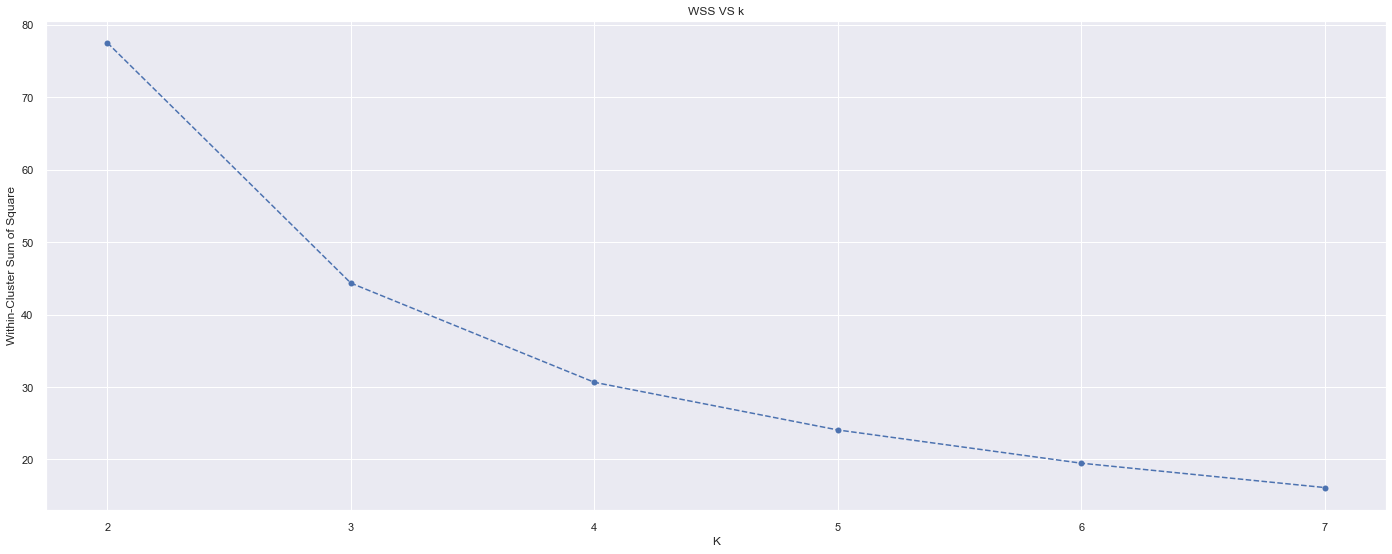

In [42]:
wss = []
for k in clusters:
    # model definition  
    kmeans = c.KMeans( init='random', n_clusters=k, n_init=10, max_iter=300 )
    # model training 
    kmeans.fit( X )
    # validation 
    wss.append(kmeans.inertia_)
    
# plot wss - ELBOW METHOD 
# tenho que escolher o lugar que o ponto mais se desloca e testar para saber o cluster para utilizar nesse exemplo foi 3 e 5
plt.plot (clusters, wss,linestyle='--', marker='o', color='b')
plt.xlabel ( 'K');
plt.ylabel ( 'Within-Cluster Sum of Square')
plt.title( 'WSS VS k');

In [173]:
# from yellowbrick.cluster import KElbowVisualizer

# kmeans = KElbowVisualizer( c.KMeans(), k=clusters, timinings=False)
# kmeans.fit( X )
# kmeans.show()

## 7.2. Sillhouette Score


In [44]:
# from yellowbrick.cluster import KElbowVisualizer

# kmeans = KElbowVisualizer( c.KMeans(), k=clusters, metric='silhouette', timinings=False)
# kmeans.fit( X )
# kmeans.show()
# problema com modulo

SyntaxError: invalid syntax (1816291965.py, line 6)

## 7.3. Silhouette Analysis


In [43]:
# fig, ax = plt.subplot (3,2,figsize(25,18))

# for k in clusters:
#     km = c.KMeans (n_cluster=k, init='random', n_init=10,max_iter=100, random_state=42)
#     q,mod = divmod( k, 2) #configurando pra colocar os dados em cada figura > fazendo divisão por 0 pegando o primeiro numero da lista
#     visualizer = SilhouetteVisualizer( km, colors='yellowbrick', ax = ax[q-1][mod])
#     visualizer.fit(X)
#     visualizer.finalize()

ValueError: num must be 1 <= num <= 6, not None

<Figure size 1800x1296 with 0 Axes>

# <font color='red'> 8.0. Model Training </font>


## 8.1. K-Means


In [46]:
# model definition
k = 6 #valor de cluster do kmeans
kmeans= c.KMeans( init= 'random', n_clusters=k, n_init=10, max_iter=300, random_state=42) # init='random' modo aleatorio porem igual sempre q rodar

#model training 
kmeans.fit( X )

# clustering 
labels = kmeans.labels_

## 8.2. Cluster Validation


In [47]:
## WSS ( Within-cluster sum of square)
print( 'WSS value {}'.format( kmeans.inertia_))

## SS ( Silhouette Score)
print( 'SS value: {}'.format(m.silhouette_score ( X, labels, metric='euclidean')))


WSS value 19.477648271397452


AttributeError: 'DataFrame' object has no attribute 'silhouette_score'

# <font color='red'> 9.0. Cluster Analysis </font>


In [48]:
df9 = df6.copy()
df9['cluster'] = labels
df9.head()

,customer_id,gross_revenue,recency_days,invoice_no,avg_ticket,returns,cluster
0,17850,0.019301,0.997319,0.160976,0.000208,0.000494,1
1,13047,0.011567,0.150134,0.039024,0.000218,0.000432,5
2,12583,0.024009,0.005362,0.068293,0.000347,0.000617,4
3,13748,0.003384,0.254692,0.019512,0.000412,0.000000,5
4,15100,0.003125,0.892761,0.009756,0.003756,0.000272,1


## 9.1. Visualization Inspection


In [49]:
visualizer = SilhouetteVisualizer (kmeans, colors='yeloowbrick')
visualizer.fit( X )
visualizer.finalize()

C:\Users\Yves Moura\.conda\envs\DataScienceEmProducao\lib\site-packages\sklearn\base.py:451: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  "X does not have valid feature names, but"


YellowbrickValueError: 'yeloowbrick' is not a valid value for name; supported values are 'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'crest', 'crest_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'flare', 'flare_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'icefire', 'icefire_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'mako', 'mako_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'rocket', 'rocket_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'vlag', 'vlag_r', 'winter', 'winter_r'

In [50]:
# fig = px.scatter_3d( df9, x='recency_days', y='invoice_no', z='gross_revenue', color='cluster')
# fig.show()

## 9.2. 2d plot


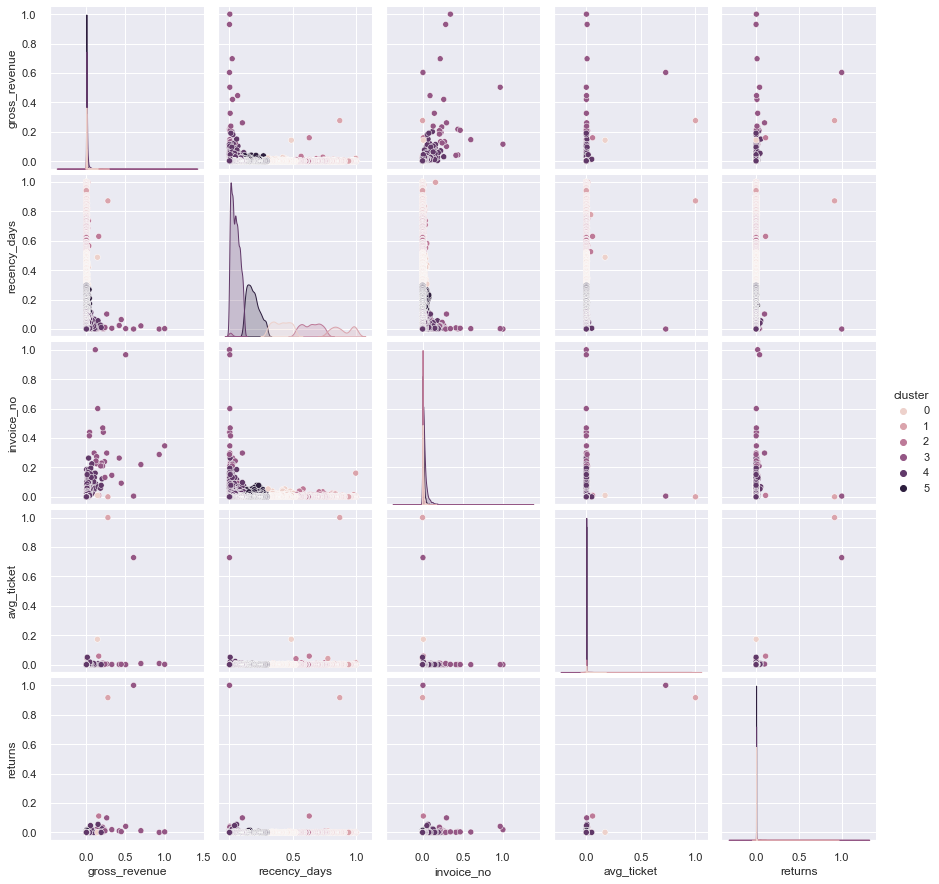

In [51]:
df_viz = df9.drop( columns='customer_id', axis=1)
sns.pairplot( df_viz, hue='cluster')

## 9.3. UMAP


<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

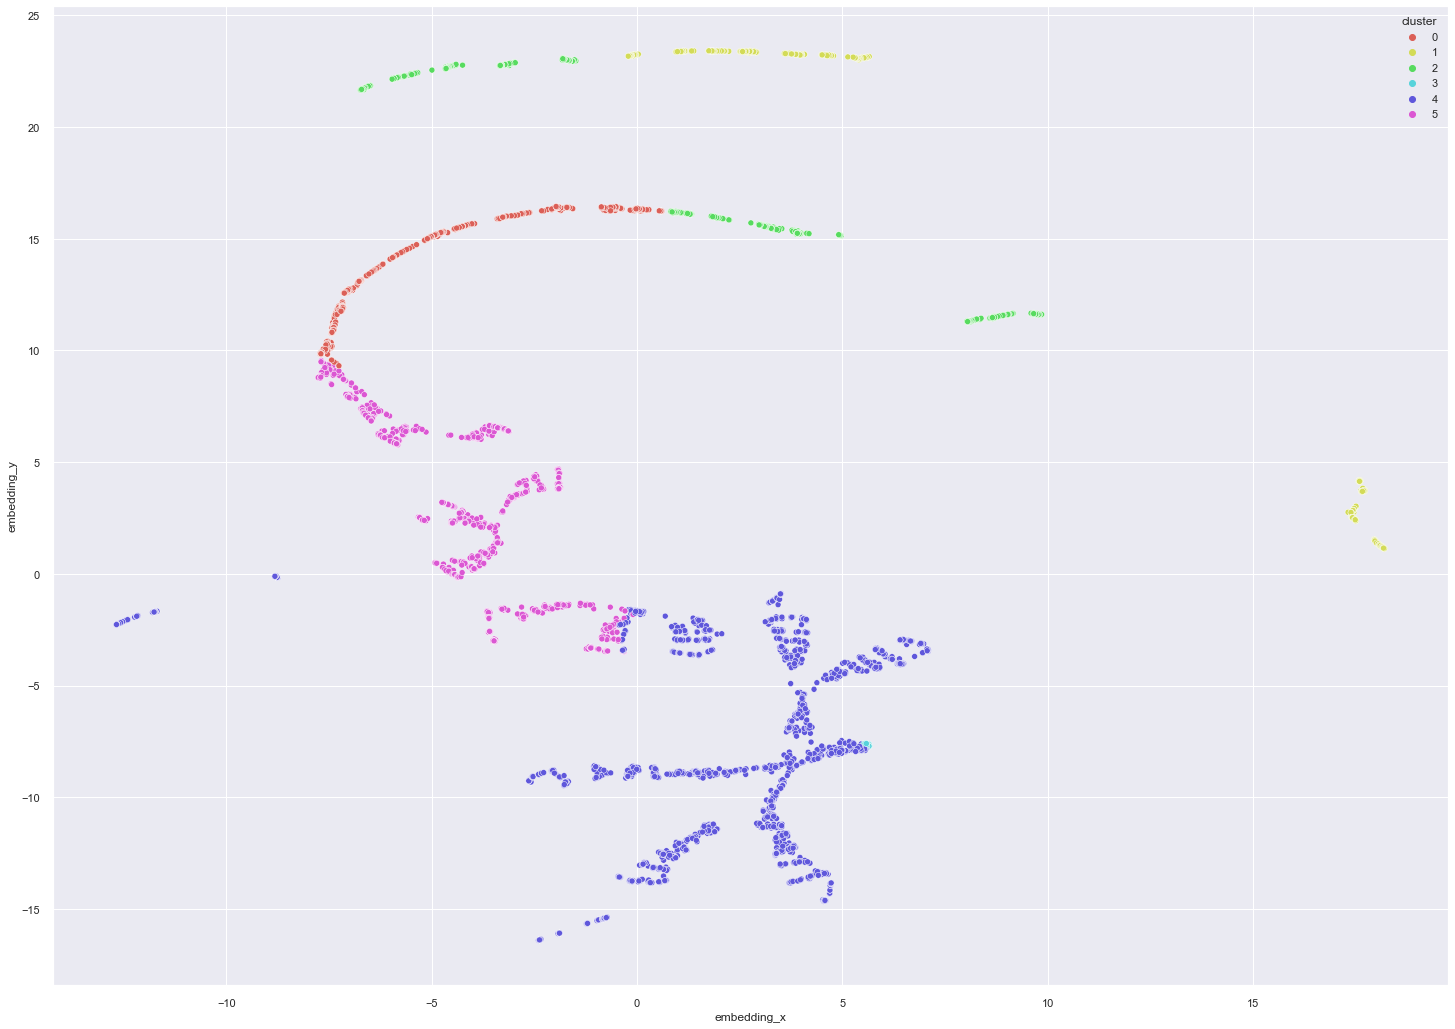

In [52]:
reducer = umap.UMAP( n_neighbors=40,random_state=42 )
embedding = reducer.fit_transform( X )

# embedding
df_viz['embedding_x'] = embedding[:, 0]
df_viz['embedding_y'] = embedding[:, 1]

# plot UMAP
sns.scatterplot( x='embedding_x', y='embedding_y', 
                 hue='cluster', 
                 palette=sns.color_palette( 'hls', n_colors=len( df_viz['cluster'].unique() ) ),
                 data=df_viz )

## 9.2. Cluster Profle


In [127]:
# Number of customer 
df_cluster = df9[['customer_id', 'cluster']].groupby('cluster').count().reset_index()
df_cluster['perc_customer'] = 100* (df_cluster['customer_id'] / df_cluster['customer_id'].sum())

# Avg Gross revenue 
df_avg_gross_revenue = df9[['gross_revenue', 'cluster']].groupby( 'cluster').mean().reset_index()
df_cluster = pd.merge( df_cluster, df_avg_gross_revenue, how='inner', on='cluster')

# Avg recency days
df_avg_gross_days = df9[['recency_days', 'cluster']].groupby( 'cluster').mean().reset_index()
df_cluster = pd.merge( df_cluster, df_avg_gross_days, how='inner', on='cluster')

# Avg invoice_no
df_avg_gross_no = df9[['invoice_no', 'cluster']].groupby( 'cluster').mean().reset_index()
df_cluster = pd.merge( df_cluster, df_avg_gross_no, how='inner', on='cluster')

# Avg Ticket
df_ticket = df9[['avg_ticket', 'cluster']].groupby( 'cluster').mean().reset_index()
df_cluster = pd.merge( df_cluster, df_ticket, how='inner', on='cluster')


df_cluster

,cluster,customer_id,perc_customer,gross_revenue,recency_days,invoice_no,avg_ticket
0,0,4071,93.115279,946.696250,96.969295,3.641120,25.359654
1,1,6,0.137237,182181.981667,7.166667,89.000000,253.626345
2,2,28,0.640439,42614.387143,6.178571,57.821429,162.862605
3,3,267,6.107045,8089.028652,20.280899,19.528090,62.783157


## Cluster 01: ( Candidato à Insider)

    - Número de customers: 6 (0.14% do customers)
    - Recência em média: 7 dias
    - Compras em média: 89 compras
    - Receita em média: 182.182,00 dólares

## Cluster 02:

    - Número de customers: 31 (0.71% do customers)
    - Recência em média: 14 dias
    - Compras em média: 53 compras
    - Receita em média: 40.543,00 dólares

## Cluster 03:

    - Número de customers: 4.335 (99% do customers)
    - Recência em média: 92 dias
    - Compras em média: 5 compras
    - Receita em média: 1.372,57 dólares


# <font color='red'> 10.0. Deploy to Production </font>
